# Super Resolution Inference with AMD MIGraphX
This notebook is inspired from: https://github.com/onnx/models/blob/master/vision/super_resolution/sub_pixel_cnn_2016/dependencies/Run_Super_Resolution_Model.ipynb

## Install Dependencies

In [1]:
!pip3 install --upgrade pip #needed for opencv-python installation
!pip3 install -r requirements.txt
!pip3 install opencv-python

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from resizeimage import resizeimage
%matplotlib inline

## Download ONNX Model

In [3]:
!wget -nc https://github.com/onnx/models/raw/master/vision/super_resolution/sub_pixel_cnn_2016/model/super-resolution-10.onnx

File ‘super-resolution-10.onnx’ already there; not retrieving.



## Import MIGraphX Python Module

In [4]:
import migraphx

# Preprocessing Image

In [5]:
orig_img = Image.open("./cat.jpg")
print(orig_img.size)
img = resizeimage.resize_cover(orig_img, [224,224], validate=False)
img_ycbcr = img.convert('YCbCr')
img_y_0, img_cb, img_cr = img_ycbcr.split()
img_ndarray = np.asarray(img_y_0)

img_4 = np.expand_dims(np.expand_dims(img_ndarray, axis=0), axis=0)
img_5 = img_4.astype(np.float32) / 255.0
img_5

(400, 400)


array([[[[0.7058824 , 0.7019608 , 0.7019608 , ..., 0.68235296,
          0.6745098 , 0.6666667 ],
         [0.7058824 , 0.7058824 , 0.7058824 , ..., 0.6784314 ,
          0.6784314 , 0.6666667 ],
         [0.70980394, 0.70980394, 0.7137255 , ..., 0.6745098 ,
          0.6745098 , 0.6627451 ],
         ...,
         [0.7607843 , 0.77254903, 0.75686276, ..., 0.5921569 ,
          0.59607846, 0.60784316],
         [0.70980394, 0.7294118 , 0.7372549 , ..., 0.62352943,
          0.61960787, 0.61960787],
         [0.7019608 , 0.69803923, 0.7058824 , ..., 0.6313726 ,
          0.62352943, 0.63529414]]]], dtype=float32)

# Run Model

In [6]:
model = migraphx.parse_onnx("super-resolution-10.onnx")
model.compile(migraphx.get_target("gpu"))
#model.print()

print(model.get_parameter_names())
print(model.get_parameter_shapes())


result = model.run({
         "input": img_5
     })

data = np.array(result[0])[0]

['input']
{'input': float_type, {1, 1, 224, 224}, {50176, 50176, 224, 1}}


# Postprocessing Image

(672, 672)


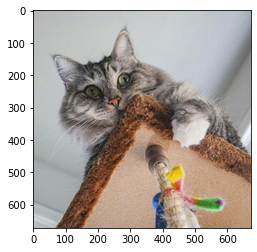

In [7]:
img_out_y = Image.fromarray(np.uint8((data* 255.0).clip(0, 255)[0]), mode='L')
# get the output image follow post-processing step from PyTorch implementation
final_img = Image.merge(
    "YCbCr", [
        img_out_y,
        img_cb.resize(img_out_y.size, Image.BICUBIC),
        img_cr.resize(img_out_y.size, Image.BICUBIC),
    ]).convert("RGB")
fig = plt.figure(figsize=(16, 16))
plt.imshow(final_img)
final_img.save("output.jpg")
print(final_img.size)

In [16]:
## PSNR Comparison Output vs Input

PSNR Value = 26.765 db


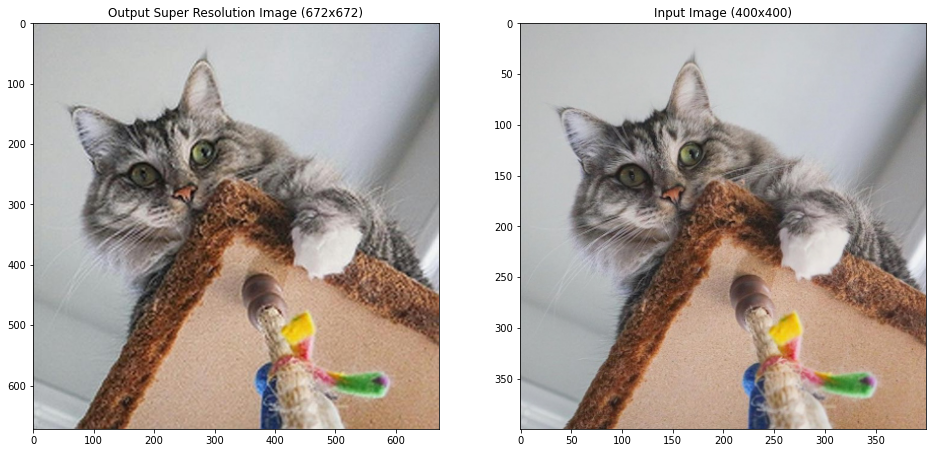

In [17]:
import cv2

imgIN = cv2.imread('cat.jpg')
imgOUT = cv2.imread('output.jpg')
imgIN = cv2.cvtColor(imgIN, cv2.COLOR_BGR2RGB) #BGR to RGB
imgOUT = cv2.cvtColor(imgOUT, cv2.COLOR_BGR2RGB)

imgIN_resized = cv2.resize(imgIN, (672,672)) #Resizing input to 672

psnr = cv2.PSNR(imgIN_resized, imgOUT) #dimensions need to be same
print("PSNR Value = %.3f db"%psnr)

fig = plt.figure(figsize=(16, 16))
sp1 = fig.add_subplot(1, 2, 1)
sp1.title.set_text('Output Super Resolution Image (%sx%s)'%(imgOUT.shape[0], imgOUT.shape[1]))
plt.imshow(imgOUT)

sp2 = fig.add_subplot(1, 2, 2)
sp2.title.set_text('Input Image (%sx%s)'%(imgIN.shape[0], imgIN.shape[1]))
plt.imshow(imgIN)
plt.show()

## 